# **Part A**
Count / Frequency based Naive Bayes Classifier

In [7]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score
)

# =======================================================
# TODOs have been implemented below
# =======================================================


# Data loading function (DO NOT CHANGE)
def load_pubmed_rct_file(filepath):
    """
    Reads a .txt file from the PubMed 20k RCT dataset.
    Returns a DataFrame with 'label' and 'sentence'.
    """
    labels, sentences = [], []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line or '\t' not in line:
                continue
            label, sent = line.split('\t', maxsplit=1)
            labels.append(label)
            sentences.append(sent)
    return pd.DataFrame({'label': labels, 'sentence': sentences})


# Implementing Multinomial Naive Bayes from scratch
class NaiveBayesClassifier:
    """
    Multinomial Naive Bayes Classifier implemented from scratch.
    It is suitable for both Count and TF-IDF features.
    """
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        self.class_priors = {}
        self.feature_log_probs = {}
        self.classes = None
        self.vocabulary_size = 0

    def fit(self, X_counts, y):
        y_array = y.to_numpy()
        self.classes = np.unique(y_array)
        self.vocabulary_size = X_counts.shape[1]

        for c in self.classes:
            X_c = X_counts[y_array == c]

            # // TODO 1: Calculate the log prior and store it in self.class_priors[c]
            self.class_priors[c] = np.log(X_c.shape[0] / X_counts.shape[0])

            feature_sum = X_c.sum(axis=0).A1
            total_mass = np.sum(feature_sum)

            # Apply Laplace smoothing
            # // TODO 2: Calculate the numerator (with Laplace smoothing)
            numerator = feature_sum + self.alpha

            # // TODO 3: Calculate the denominator (with Laplace smoothing)
            denominator = total_mass + self.alpha * self.vocabulary_size

            # // TODO 4: Calculate the log likelihood (log(numerator / denominator))
            self.feature_log_probs[c] = np.log(numerator / denominator)

    def predict(self, X_counts):
        y_pred = []
        for i in range(X_counts.shape[0]):
            scores = {}

            x_i = X_counts.getrow(i)

            for c in self.classes:
                log_prob = self.class_priors[c]
                log_likelihoods = self.feature_log_probs[c]

                non_zero_indices = x_i.indices
                non_zero_data = x_i.data

                # // TODO 5: Complete the log probability calculation for the likelihood term
                log_prob += np.sum(non_zero_data * log_likelihoods[non_zero_indices])
                scores[c] = log_prob

            # // TODO 6: Find the key (class label) with the maximum score
            predicted_class = max(scores, key=scores.get)

            y_pred.append(predicted_class)

        # // TODO 7: Return the final predictions array
        return np.array(y_pred)


In [11]:
# Load and Prepare Data (DO NOT CHANGE)
dir_path = './'
try:
    train_df = load_pubmed_rct_file(os.path.join(dir_path, 'train.txt'))
    dev_df   = load_pubmed_rct_file(os.path.join(dir_path, 'dev.txt'))
    test_df  = load_pubmed_rct_file(os.path.join(dir_path, 'test.txt'))

    # train_df = pd.DataFrame({'label': ['BACKGROUND'], 'sentence': ['placeholder']})
    # dev_df   = pd.DataFrame({'label': ['BACKGROUND'], 'sentence': ['placeholder']})
    # test_df  = pd.DataFrame({'label': ['BACKGROUND'], 'sentence': ['placeholder']})


    print(f"Train samples: {len(train_df)}")
    print(f"Dev   samples: {len(dev_df)}")
    print(f"Test  samples: {len(test_df)}")

    X_train, y_train = train_df['sentence'], train_df['label']
    X_dev,   y_dev   = dev_df['sentence'],   dev_df['label']
    X_test,  y_test  = test_df['sentence'],  test_df['label']
    target_names = sorted(y_train.unique())
    print(f"Classes: {target_names}")

except FileNotFoundError as e:
    print(f"Error: Dataset file not found. Please ensure the files are uploaded.")
    X_train, y_train = pd.Series([]), pd.Series([])
    X_test, y_test = pd.Series([]), pd.Series([])
    target_names = []

Train samples: 2211861
Dev   samples: 28932
Test  samples: 29493
Classes: ['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS']


In [12]:
# Feature Extraction and Custom Model Training
if X_train is not None and len(X_train) > 0:

    # Initialize and fit the CountVectorizer for count-based features
    count_vectorizer = CountVectorizer(
        lowercase=True,
        strip_accents='unicode',
        stop_words='english',
        # Include both unigrams and bigrams
        ngram_range=(1, 2),
        # Allow words appearing in at least one document
        min_df=1
    )

    print("Fitting Count Vectorizer and transforming training data...")
    X_train_counts = count_vectorizer.fit_transform(X_train)
    if X_train_counts is not None:
        print(f"Vocabulary size: {X_train_counts.shape[1]}")

    print("Transforming test data...")
    X_test_counts = count_vectorizer.transform(X_test)

    # Train Custom Naive Bayes Classifier
    print("\nTraining the Custom Naive Bayes Classifier (from scratch)...")

    nb_model = NaiveBayesClassifier(alpha=1.0)
    nb_model.fit(X_train_counts, y_train)

    print("Training complete.")

else:
    print("Skipping feature extraction and training: Training data is empty or not loaded.")


Fitting Count Vectorizer and transforming training data...
Vocabulary size: 6900672
Transforming test data...

Training the Custom Naive Bayes Classifier (from scratch)...
Training complete.


In [13]:
# Predict and evaluate on test set
print("\n=== Test Set Evaluation (Custom Count-Based Naive Bayes) ===")

# // TODO: Predict y_test_pred using X_test_counts
y_test_pred = nb_model.predict(X_test_counts)

if y_test_pred is not None:
    print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
    print(classification_report(y_test, y_test_pred, target_names=target_names))
    test_f1 = f1_score(y_test, y_test_pred, average='macro')
    print(f"Macro-averaged F1 score: {test_f1:.4f}")
else:
    print("Prediction step failed or incomplete.")



=== Test Set Evaluation (Custom Count-Based Naive Bayes) ===
Accuracy: 0.7835
              precision    recall  f1-score   support

  BACKGROUND       0.67      0.41      0.51      2663
 CONCLUSIONS       0.66      0.74      0.70      4426
     METHODS       0.81      0.90      0.85      9751
   OBJECTIVE       0.67      0.55      0.60      2377
     RESULTS       0.86      0.84      0.85     10276

    accuracy                           0.78     29493
   macro avg       0.73      0.69      0.70     29493
weighted avg       0.78      0.78      0.78     29493

Macro-averaged F1 score: 0.7018


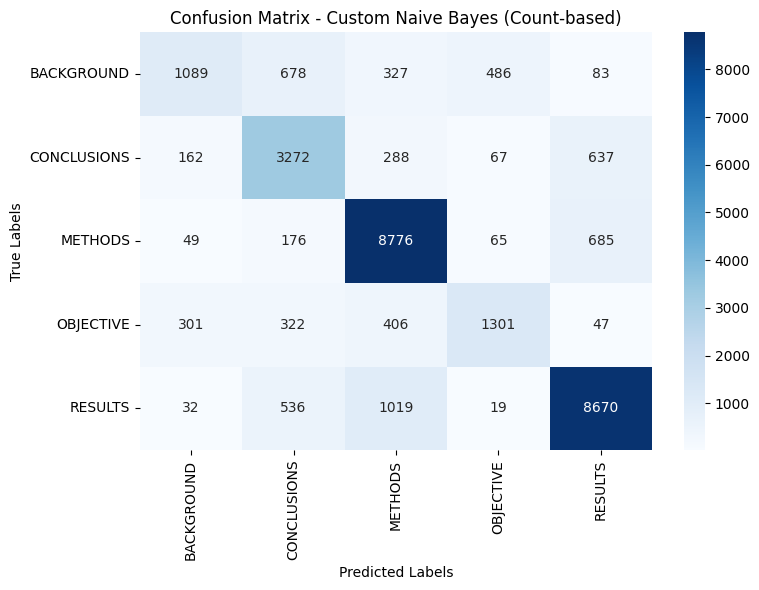

In [14]:
# Confusion Matrix on test set
    # // TODO: Use the confusion_matrix, matplotlib, and seaborn libraries to generate
    # a visual confusion matrix (heatmap) for the predicted results.
    # if y_test_pred is not None:
    #     cm = confusion_matrix(...)
    #     plt.figure(...)
    #     sns.heatmap(...)
    #     plt.show()

# Confusion Matrix on test set
if y_test_pred is not None:
    # // TODO: Use the confusion_matrix, matplotlib, and seaborn libraries to generate
    # a visual confusion matrix (heatmap) for the predicted results.
    cm = confusion_matrix(y_test, y_test_pred, labels=target_names)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names,
                yticklabels=target_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix - Custom Naive Bayes (Count-based)')
    plt.tight_layout()
    plt.show()
else:
    print("Cannot display confusion matrix: predictions not available.")


# **Part B**
TF-IDF score based Classifier

In [15]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score
)

# =======================================================
# Completed Implementation
# =======================================================

# // TODO: Define a Pipeline named 'pipeline' using TfidfVectorizer and MultinomialNB.
# Use standard initial parameters
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', lowercase=True)),
    ('nb', MultinomialNB())
])

# // TODO: Train the initial pipeline on the training set
print("Training initial Naive Bayes pipeline...")
pipeline.fit(X_train, y_train)
print("Training complete.")

# Predict and evaluate on test set
# // TODO: Predict y_test_pred and calculate metrics
print("\n=== Test Set Evaluation (Initial Sklearn Model) ===")
y_test_pred = pipeline.predict(X_test)

if y_test_pred is not None:
    print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
    print(classification_report(y_test, y_test_pred, target_names=target_names))
    print(f"Macro-averaged F1 score: {f1_score(y_test, y_test_pred, average='macro'):.4f}")
else:
    print("Initial model evaluation skipped: Predictions not available.")


# =======================================================
# Hyperparameter Tuning using GridSearchCV
# =======================================================

# // TODO: Define the parameter grid 'param_grid' to tune both TF-IDF and NB parameters.
param_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],     # unigrams or unigrams+bigrams
    'tfidf__min_df': [1, 2],                    # ignore rare terms
    'nb__alpha': [0.1, 0.5, 1.0]                # Laplace smoothing
}

# // TODO: Initialize GridSearchCV using the pipeline and param_grid.
# Ensure cv=3 and scoring='f1_macro' are used.
grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=3,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=2
)

print("\nStarting Hyperparameter Tuning on Development Set...")
# // TODO: Fit the GridSearchCV object using the development data.
grid.fit(X_dev, y_dev)
print("Grid search complete.")

if grid is not None and hasattr(grid, 'best_params_'):
    # // TODO: Print the best parameters and the corresponding best cross-validation score.
    print("\n=== Best Model Parameters and Performance ===")
    print(f"Best Parameters: {grid.best_params_}")
    print(f"Best Cross-Validation F1 Score: {grid.best_score_:.4f}")
else:
    print("Hyperparameter tuning skipped: Grid Search object not initialized or fitted.")


Training initial Naive Bayes pipeline...
Training complete.

=== Test Set Evaluation (Initial Sklearn Model) ===
Accuracy: 0.7384
              precision    recall  f1-score   support

  BACKGROUND       0.62      0.34      0.44      2663
 CONCLUSIONS       0.61      0.64      0.63      4426
     METHODS       0.76      0.86      0.81      9751
   OBJECTIVE       0.72      0.36      0.48      2377
     RESULTS       0.79      0.86      0.82     10276

    accuracy                           0.74     29493
   macro avg       0.70      0.61      0.63     29493
weighted avg       0.73      0.74      0.72     29493

Macro-averaged F1 score: 0.6345

Starting Hyperparameter Tuning on Development Set...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Grid search complete.

=== Best Model Parameters and Performance ===
Best Parameters: {'nb__alpha': 0.1, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2)}
Best Cross-Validation F1 Score: 0.6027


# **Part C**
Bayes Optimal Classifier

In [16]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, VotingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# =======================================================
# TODO: Implement the following steps:
# 1. Define the five diverse hypothesis pipelines (H1 to H5) using TfidfVectorizer
#    and the specified classifiers (NB, LR, RF, DT, KNN).
# 2. Train each of the five hypotheses on the sampled training data.
# 3. Create a list of estimators for the VotingClassifier.
# 4. Initialize and fit the VotingClassifier (Bayes Optimal Classifier approximation).
# 5. Make final predictions and evaluate the BOC performance on the test data.
# =======================================================

# Sampling for faster training of multiple models (DO NOT CHANGE)
#
# *** STUDENT ACTION REQUIRED ***
# This section dynamically calculates the sample size based on the student's SRN.
# When running this cell, a prompt will appear asking for the full SRN.
#
BASE_SAMPLE_SIZE = 10000

FULL_SRN = input("Please enter your full SRN (e.g., PES1UG22CS345): ")

try:
    if len(FULL_SRN) >= 3:
        print("My SRN is" + FULL_SRN)
        srn_suffix_str = FULL_SRN[-3:]
        srn_value = int(srn_suffix_str)
    else:
        raise ValueError("SRN too short.")
except (ValueError, IndexError):
    print("WARNING: SRN input failed or format is incorrect. Using 10000.")
    srn_value = 0

SAMPLE_SIZE = BASE_SAMPLE_SIZE + srn_value

print(f"Using dynamic sample size: {SAMPLE_SIZE}")

# Assuming X_train and y_train were loaded in Part A
# Placeholder initialization in case data wasn't loaded in the environment
if 'X_train' not in locals() or len(X_train) == 0:
    print("Warning: Training data not found. Using small placeholder data.")
    X_train = pd.Series(["sample text one", "sample text two", "sample text three"])
    y_train = pd.Series(["BACKGROUND", "METHODS", "RESULTS"])
    X_test = pd.Series(["test text one", "test text two"])
    y_test = pd.Series(["BACKGROUND", "METHODS"])
    target_names = ["BACKGROUND", "CONCLUSIONS", "METHODS", "OBJECTIVE", "RESULTS"]

# Create the sampled training subset
# Ensure SAMPLE_SIZE does not exceed the size of the actual training data
effective_sample_size = min(SAMPLE_SIZE, len(X_train))
X_train_sampled = X_train[:effective_sample_size]
y_train_sampled = y_train[:effective_sample_size]
print(f"Actual sampled training set size used: {effective_sample_size}")

X_train_sampled = X_train[:SAMPLE_SIZE]
y_train_sampled = y_train[:SAMPLE_SIZE]
print(f"Using {len(X_train_sampled)} samples for training base models.")

# Base TF-IDF parameters (DO NOT CHANGE)
tfidf_params = {
    'lowercase': True,
    'strip_accents': 'unicode',
    'stop_words': 'english',
    'ngram_range': (1, 1),
    'min_df': 5
}

# Define the five diverse hypotheses/pipelines

# Multinomial Naive Bayes
h1_nb = Pipeline([('tfidf', TfidfVectorizer(**tfidf_params)),
                  ('clf', MultinomialNB(alpha=1.0, fit_prior=False))])

# Logistic Regression
h2_lr = Pipeline([('tfidf', TfidfVectorizer(**tfidf_params)),
                  ('clf', LogisticRegression(solver='liblinear', multi_class='auto', max_iter=1000, random_state=42))])

# Random Forest Classifier
h3_rf = Pipeline([('tfidf', TfidfVectorizer(**tfidf_params)),
                  ('clf', RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1))])

# Decision Tree Classifier
h4_dt = Pipeline([('tfidf', TfidfVectorizer(**tfidf_params)),
                  ('clf', DecisionTreeClassifier(max_depth=10, random_state=42))])

# K-Nearest Neighbors
h5_knn = Pipeline([('tfidf', TfidfVectorizer(**tfidf_params)),
                  ('clf', KNeighborsClassifier(n_neighbors=5, n_jobs=-1))])

hypotheses = [h1_nb, h2_lr, h3_rf, h4_dt, h5_knn]
hypothesis_names = ['NaiveBayes', 'LogisticRegression', 'RandomForest', 'DecisionTree', 'KNN']

Please enter your full SRN (e.g., PES1UG22CS345): PES2UG23CS485
My SRN isPES2UG23CS485
Using dynamic sample size: 10485
Actual sampled training set size used: 10485
Using 10485 samples for training base models.


In [18]:
# // TODO: Train all five hypotheses on X_train_sampled and y_train_sampled using a for loop
for name, model in zip(hypothesis_names, hypotheses):
    print(f"Training {name}...")
    model.fit(X_train_sampled, y_train_sampled)
print("All base models trained.")


Training NaiveBayes...
Training LogisticRegression...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Training RandomForest...
Training DecisionTree...
Training KNN...
All base models trained.


In [19]:
# Implement and Evaluate the Bayes Optimal Classifier

# List of (name, estimator) tuples for the VotingClassifier
estimators = list(zip(hypothesis_names, hypotheses))

# Hard Voting (Majority Rule) for BOC approximation
# // TODO: Initialize the VotingClassifier using 'estimators'
from sklearn.ensemble import VotingClassifier

boc_hard_voter = VotingClassifier(estimators=estimators, voting='hard', n_jobs=-1)

print("\nFitting the VotingClassifier (BOC approximation)...")
# // TODO: Fit the VotingClassifier using the sampled training data
boc_hard_voter.fit(X_train_sampled, y_train_sampled)

# Make the final BOC prediction on the test set
# // TODO: Predict y_boc_pred using X_test
y_boc_pred = boc_hard_voter.predict(X_test)



Fitting the VotingClassifier (BOC approximation)...


In [20]:
# Evaluate the Bayes Optimal Classifier (BOC)
print("\n=== Final Evaluation: Bayes Optimal Classifier (Hard Voting) ===")

if y_boc_pred is not None:
    # // TODO: Define Accuracy and Macro F1 Score
    boc_accuracy = accuracy_score(y_test, y_boc_pred)
    boc_f1 = f1_score(y_test, y_boc_pred, average='macro')

    print(f"BOC Accuracy: {boc_accuracy:.4f}")
    print(f"BOC Macro F1 Score: {boc_f1:.4f}")
    print(classification_report(y_test, y_boc_pred, target_names=target_names))
else:
    print("Evaluation skipped: Predictions not available.")



=== Final Evaluation: Bayes Optimal Classifier (Hard Voting) ===
BOC Accuracy: 0.6805
BOC Macro F1 Score: 0.5582
              precision    recall  f1-score   support

  BACKGROUND       0.45      0.32      0.37      2663
 CONCLUSIONS       0.64      0.47      0.54      4426
     METHODS       0.62      0.92      0.74      9751
   OBJECTIVE       0.79      0.23      0.35      2377
     RESULTS       0.83      0.74      0.79     10276

    accuracy                           0.68     29493
   macro avg       0.67      0.54      0.56     29493
weighted avg       0.70      0.68      0.66     29493



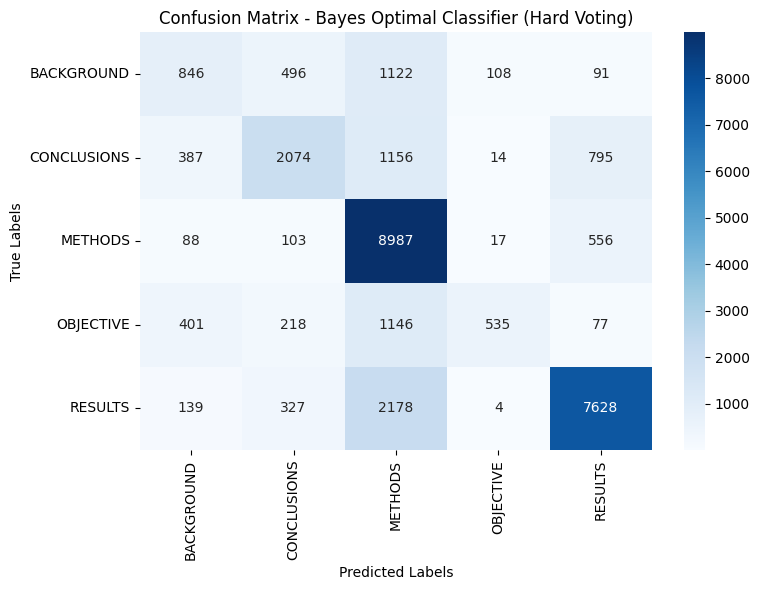

In [21]:
# // TODO: Generate and visualize the Confusion Matrix (heatmap) for the BOC predictions.
if y_boc_pred is not None:
    cm = confusion_matrix(y_test, y_boc_pred, labels=target_names)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names, yticklabels=target_names)
    plt.title("Confusion Matrix - Bayes Optimal Classifier (Hard Voting)")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.tight_layout()
    plt.show()
else:
    print("Confusion matrix visualization skipped: Predictions not available.")


Part C Draft

In [23]:
from sklearn.model_selection import train_test_split



Training all base models...
Training NaiveBayes...
Training LogisticRegression...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Training RandomForest...
Training DecisionTree...
Training KNN...
All base models trained.

Calculating posterior weights (P(h_i | D)) using validation data...
NaiveBayes: Validation F1 = 0.5925


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression: Validation F1 = 0.5859
RandomForest: Validation F1 = 0.3005
DecisionTree: Validation F1 = 0.3395
KNN: Validation F1 = 0.1105
Posterior Weights (Normalized): [0.30717699 0.30377004 0.1557833  0.17599622 0.05727346]

Fitting the VotingClassifier (BOC approximation)...
Fitting complete.

Predicting on test set...

=== Final Evaluation: Bayes Optimal Classifier (Soft Voting) ===
BOC Accuracy: 0.7169
BOC Macro F1 Score: 0.6096

Classification Report:

              precision    recall  f1-score   support

  BACKGROUND       0.53      0.30      0.38      2663
 CONCLUSIONS       0.63      0.51      0.56      4426
     METHODS       0.69      0.90      0.78      9751
   OBJECTIVE       0.75      0.39      0.51      2377
     RESULTS       0.80      0.82      0.81     10276

    accuracy                           0.72     29493
   macro avg       0.68      0.58      0.61     29493
weighted avg       0.71      0.72      0.70     29493



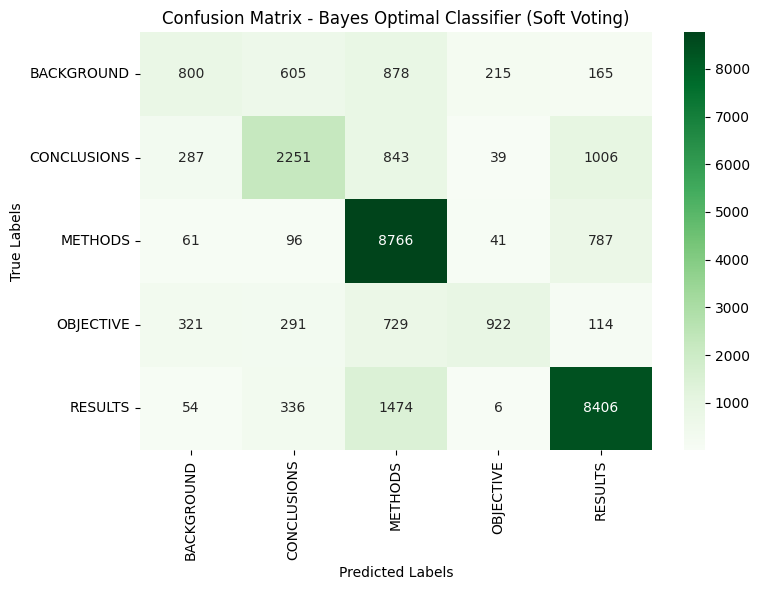

In [24]:
# // TODO: Train all five hypotheses on X_train_sampled and y_train_sampled using a for loop.
print("\nTraining all base models...")
for name, model in zip(hypothesis_names, hypotheses):
    print(f"Training {name}...")
    model.fit(X_train_sampled, y_train_sampled)
print("All base models trained.")


# // TODO: Implement the Posterior Weight Calculation (P(h_i | D)).
# Split training data into train_sub and val_sub for model evaluation.
X_train_sub, X_val_sub, y_train_sub, y_val_sub = train_test_split(
    X_train_sampled, y_train_sampled, test_size=0.2, random_state=42
)

posterior_scores = []
print("\nCalculating posterior weights (P(h_i | D)) using validation data...")
for name, model in zip(hypothesis_names, hypotheses):
    # Refit model on the smaller train_sub
    model.fit(X_train_sub, y_train_sub)
    # Evaluate on validation subset
    y_val_pred = model.predict(X_val_sub)
    f1 = f1_score(y_val_sub, y_val_pred, average='macro')
    posterior_scores.append(f1)
    print(f"{name}: Validation F1 = {f1:.4f}")

# Normalize to get posterior weights
posterior_weights = np.array(posterior_scores) / np.sum(posterior_scores)
print(f"Posterior Weights (Normalized): {posterior_weights}")


# Implement and Evaluate the Bayes Optimal Classifier
estimators = list(zip(hypothesis_names, hypotheses))

# BOC is approximated using soft voting with posterior weights
boc_soft_voter = VotingClassifier(
    estimators=estimators,
    voting='soft',
    weights=posterior_weights,
    n_jobs=-1
)

print("\nFitting the VotingClassifier (BOC approximation)...")
# // TODO: Fit the VotingClassifier using the full sampled training data (X_train_sampled, y_train_sampled)
boc_soft_voter.fit(X_train_sampled, y_train_sampled)
print("Fitting complete.")


# Make the final BOC prediction on the test set
print("\nPredicting on test set...")
# // TODO: Predict y_pred using X_test, and then calculate and visualize evaluation metrics.
y_pred = boc_soft_voter.predict(X_test)


# Final Evaluation (STUDENT TASK)
print("\n=== Final Evaluation: Bayes Optimal Classifier (Soft Voting) ===")

if y_pred is not None:
    boc_accuracy = accuracy_score(y_test, y_pred)
    boc_f1 = f1_score(y_test, y_pred, average='macro')

    print(f"BOC Accuracy: {boc_accuracy:.4f}")
    print(f"BOC Macro F1 Score: {boc_f1:.4f}")
    print("\nClassification Report:\n")
    print(classification_report(y_test, y_pred, target_names=target_names))

    # // TODO: Generate and visualize the Confusion Matrix (heatmap) for the BOC predictions.
    cm = confusion_matrix(y_test, y_pred, labels=target_names)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
                xticklabels=target_names, yticklabels=target_names)
    plt.title("Confusion Matrix - Bayes Optimal Classifier (Soft Voting)")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.tight_layout()
    plt.show()
else:
    print("Evaluation skipped: Predictions not generated.")
